# Seasonality in observations



Daily temperature data presents a strong seasonal signal. We can then write the times eries as:

$T(t) = x_t + g(t)$

where $x_t$ is the stationary stochastic component and $g(t)$ is the deterministic component.

The purpose of this assignment is to **evaluate the $95^{th}$ percentile of monthly temperature**. The steps to follow are:

* extrapolate monthly maxima from daily observations
* remove the seasonal signal
* fit a distribution function on stochastic component
* evaluate the $95^{th}$ percentile including the seasonal component

The temperature data refers to Hoek van Holland (source KNMI - https://www.knmi.nl/nederland-nu/klimatologie/daggegevens)
The **data are given in 0.1 degrees Celsius** (you have to divide them by 10 to obtain the data in degree Celsius)


In [1]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

**Load Data.** Run the following cell to read the daily data

In [2]:
# Open and read the given data
df = pd.read_csv('HvH_temp_v2.csv', sep=';')

# Convert 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'], format="%d-%m-%Y %H:%M")

# Extract year, month, and day components
df['YY'] = df['date_time'].dt.year
df['MM'] = df['date_time'].dt.month
df['DD'] = df['date_time'].dt.day

print(df) # to see all the variables of the dataframe

                 date_time  temp    YY  MM  DD
0      2001-01-01 00:00:00     2  2001   1   1
1      2001-01-01 01:00:00     4  2001   1   1
2      2001-01-01 02:00:00     0  2001   1   1
3      2001-01-01 03:00:00     1  2001   1   1
4      2001-01-01 04:00:00    -3  2001   1   1
...                    ...   ...   ...  ..  ..
174571 2020-11-30 18:56:00    24  2020  11  30
174572 2020-11-30 19:56:00    17  2020  11  30
174573 2020-11-30 20:56:00    20  2020  11  30
174574 2020-11-30 21:56:00    17  2020  11  30
174575 2020-11-30 22:56:00    18  2020  11  30

[174576 rows x 5 columns]


**Task 1:** From the daily data, extract **monthly maxima**  

In [3]:
idx = df.groupby(['YY','MM'])['temp'].idxmax()  # Get the index of max values for each month
monthly_maxima_detailed = df.loc[idx].reset_index(drop=True) # Create a new dataset with the monthly maxima

monthly_maxima_detailed['temp'] = (monthly_maxima_detailed['temp'])/10 # divide the temperature values by 10
print(monthly_maxima_detailed)

              date_time  temp    YY  MM  DD
0   2001-01-07 12:00:00  12.3  2001   1   7
1   2001-02-04 11:00:00  13.4  2001   2   4
2   2001-03-02 13:00:00  22.5  2001   3   2
3   2001-04-09 13:00:00  26.0  2001   4   9
4   2001-05-26 14:00:00  29.4  2001   5  26
..                  ...   ...   ...  ..  ..
234 2020-07-10 12:57:00  32.6  2020   7  10
235 2020-08-15 13:57:00  31.3  2020   8  15
236 2020-09-20 12:56:00  18.9  2020   9  20
237 2020-10-02 09:56:00  18.0  2020  10   2
238 2020-11-20 20:56:00  12.3  2020  11  20

[239 rows x 5 columns]


**Task 2: Decompose the time series.** You want now to decompose the signal into the deterministic and stochastic components. The deterministic part is given by the **long-term monthly average** (e.g., T_avg_Jan, T_avg_Feb, T_avg_Mar etc.). 

Plot the monthly maxima signal and the deterministic and stochastic components.


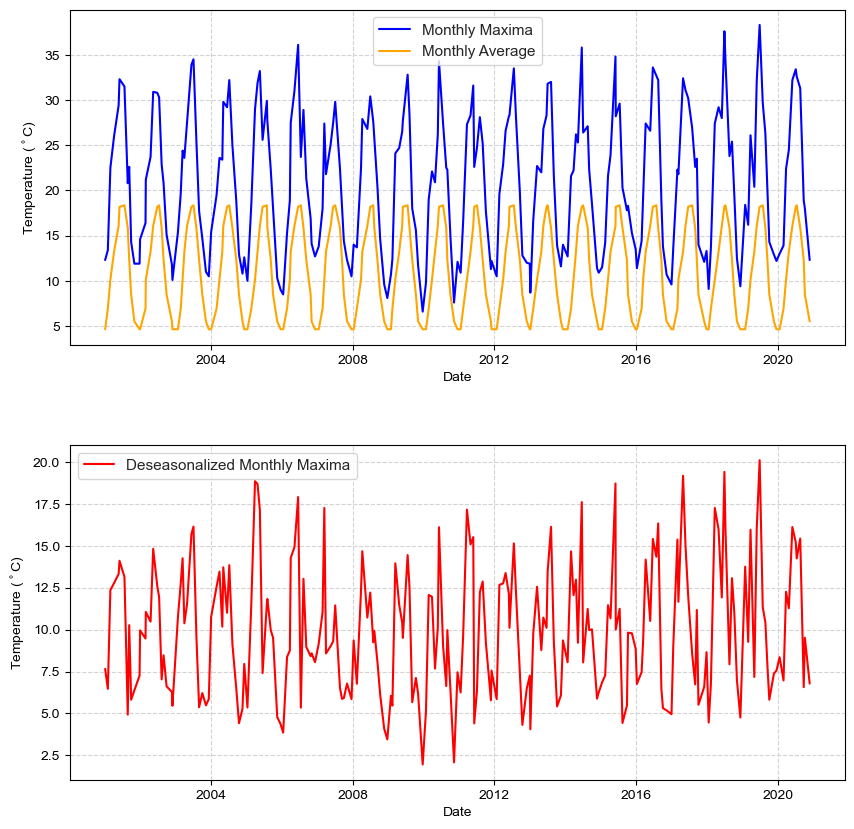

In [4]:
# write your code here
# answer:

# Monthly average
idx_avg = (df.groupby(['MM'])['temp'].mean()/10)  

# Add these values based on the month as a new column to the monthly maxima dataset
monthly_maxima_detailed['temp_avg'] = monthly_maxima_detailed['MM'].map(idx_avg)

# calculation of T_anomalies=Tmax-Tavg(of the month)
monthly_maxima_detailed['temp_anom'] = monthly_maxima_detailed['temp'] - monthly_maxima_detailed['temp_avg']

# Plot the signals
fig1 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig1, wspace=0.1, hspace=0.3)

sns.set_style(rc={'patch.force_edgecolor':True,
                   'patch.edgecolor': 'black'})

ax11 = fig1.add_subplot(gs[0, 0])
ax12 = fig1.add_subplot(gs[1, 0])

sns.set(style='whitegrid')

# Plot of the Monthly maxima per year and the average monthly average
ax11.plot(monthly_maxima_detailed['date_time'], monthly_maxima_detailed['temp'], color='blue', label='Monthly Maxima')
ax11.plot(monthly_maxima_detailed['date_time'], monthly_maxima_detailed['temp_avg'], color='orange', label='Monthly Average')
ax11.set_xlabel('Date')
ax11.set_ylabel(('Temperature ($^\circ$C)'))
ax11.legend(loc="best")
ax11.grid(True, which="both", ls="--", c='lightgray')

# Plot of the deseasonalized signal of Monthly maxima
ax12.plot(monthly_maxima_detailed['date_time'], monthly_maxima_detailed['temp_anom'], color='red', label='Deseasonalized Monthly Maxima')
ax12.set_xlabel('Date')
ax12.set_ylabel(('Temperature ($^\circ$C)'))
ax12.legend(loc="best")
ax12.grid(True, which="both", ls="--", c='lightgray')


**Task 3: modeling the stochastic component.** To make statistical inferences, you need to select a distribution function that well represents the data. Fit a GEV distribution to the stochastic component. As a goodness of fit test, plot the empirical and theoretical CDF.

Text(0, 0.5, 'CDF')

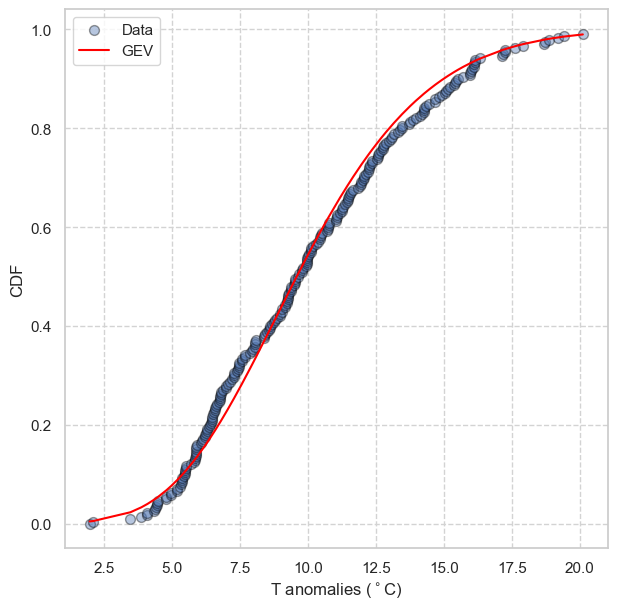

In [5]:
# write here your code here
# answer:

# empirical CDF
def ecdf(data):
    n = len(data)         # length of the data
    ecdf = []
    for i in range(0, n):
        ecdf.append(i / (len(data) + 1))
    return ecdf

temp_data = monthly_maxima_detailed

Tanom_all = np.array(temp_data['temp_anom'])
Tavg_all = np.array(temp_data['temp_avg'])
Tmax_all = np.array(temp_data['temp'])

# fit the GEV to the Tanomalies

# calculation of the parameters of the GEV distributions
params_mle_all = stats.genextreme.fit(Tanom_all, loc=Tanom_all.mean(), scale=Tanom_all.std())
c_mle_all, loc_mle_all, scale_mle_all = params_mle_all

# data sort
Tanom_sorted_all = np.sort(Tanom_all)

# theoretical (GEV) CDF
cdf_mle_gev_all = stats.genextreme.cdf(Tanom_sorted_all , c_mle_all, loc=loc_mle_all, scale=scale_mle_all)

# empirical CDF
ecdf_Tanom_all = ecdf(Tanom_sorted_all)

# Plot the empirical and theoretical CDF
fig2, ax2 = plt.subplots(figsize=(7,7))
sns.set(style='white')


ax2.scatter( Tanom_sorted_all, ecdf_Tanom_all, s=50, marker="o", edgecolor='black', alpha=0.4, label='Data')
ax2.plot(Tanom_sorted_all, cdf_mle_gev_all, '-', color='red', markersize=2, label='GEV')

plt.grid(True, which="both", ls="--", c='lightgray')
ax2.legend(loc='best')
ax2.set_xlabel('T anomalies ($^\circ$C)')
ax2.set_ylabel('CDF')

**Task 4: Calculate the $95^{th}$ percentile**. For every month you have to evaluate the $95^{th}$ percentile. Plot the percentile (y-axis) as a function of the month (x-axis). 

*Hint: The GEV in Task 3 (describing the stochastic component) should be adjusted by the monthly long-term mean (deterministic component)*

MM
1     21.362483
2     23.649773
3     26.861185
4     29.941352
5     32.800056
6     34.911081
7     35.073087
8     32.586376
9     29.049547
10    25.200547
11    22.235062
12    21.362933
Name: temp, dtype: float64


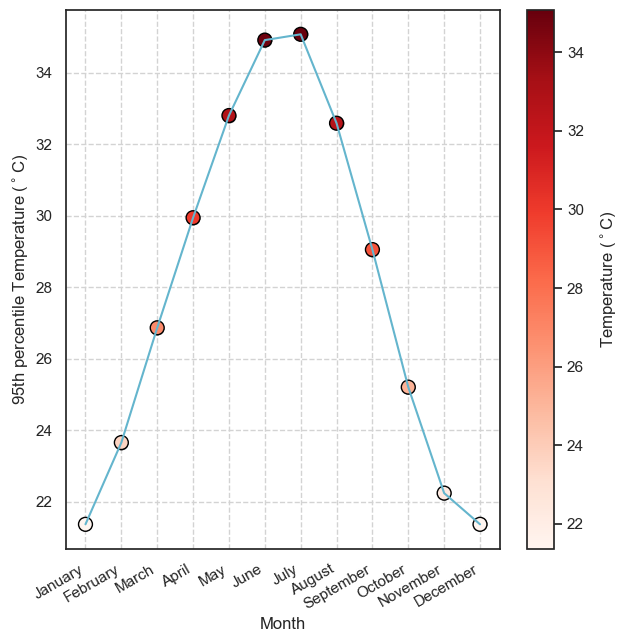

In [6]:
# write here your code here
# answer:

# inverse CDF to calculate the corresponding temperature to the 95th percentile
temp_95th_stoc = stats.genextreme.ppf(0.95 , c_mle_all, loc=loc_mle_all, scale=scale_mle_all)

# add the deterministic part of every month to the calculation from GEV
temp_95th = temp_95th_stoc + idx_avg
print(temp_95th)

# Plot for every month
fig3, ax3 = plt.subplots(figsize=(7,7))
sns.set(style='white')

Months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
          'October', 'November', 'December']

ax3.scatter(Months, temp_95th, s=80, marker="o", edgecolor='black', alpha=0.7)
my_cmap = plt.get_cmap('Reds')
scatter=plt.scatter(Months, temp_95th, vmin=min(temp_95th), vmax=max(temp_95th), c=temp_95th, cmap=my_cmap, s=100, alpha=1,marker="o", edgecolor='black')
cb=plt.colorbar(scatter)
ax3.plot(Months, temp_95th, '-', color='c', markersize=2)

plt.grid(True, which="both", ls="--", c='lightgray')
ax3.set_ylabel('95th percentile Temperature ($^\circ$C)')
ax3.set_xlabel('Month')
plt.xticks(rotation=30, ha='right')
cb.set_label(r'Temperature ($^\circ$C)', fontsize=12, labelpad=10)

<div class="alert alert-block alert-success"> 
<b>Discuss</b> Would it be possible to include the seasonal signal in the GEV distribution? Write how the parameters of the GEV distribution would look like in such a case.
</div>